In [1]:
import os

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import auc, precision_recall_curve, roc_curve
import torch
import torch.nn as nn
import torch_geometric as pyg
import torch_geometric.nn as gnn

In [2]:
np.random.seed(42)

# Functions

## Dataset

In [3]:
loaded_data = {}
def get_data(cell_type):
    # Get graph
    data_folder = './data/training_matrices_DGL/'
    if cell_type in loaded_data:
        mat = loaded_data[cell_type]
    else:
        mat = pd.read_csv(data_folder + f'{cell_type}.feat.mat', index_col=0, sep='\t')
        loaded_data[cell_type] = mat
    genes = np.array(mat.columns)
    assert (genes == np.array(mat.index)).all()

    # Get labels
    meta = pd.read_csv(data_folder + 'training_labels.txt', index_col=0, sep='\t')
    labels = meta.values[:, 0]
    labels = np.array([str(meta.loc[g]['label']) if g in meta.index else 'unknown' for g in genes])

    return mat.to_numpy(), labels, genes

## Model

In [44]:
from itertools import product
import pecanpy as pp
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPClassifier

In [ ]:
class FCL(nn.Module):
    def __init__(self, input_dim, hidden_dim=None, output_dim=1):
        super().__init__()
        
        self.input_dim = input_dim
        hidden_dim = hidden_dim if hidden_dim is not None else int(2*input_dim)
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        self.main = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid(),
        )
        
    def forward(self, X):
        return self.main(X)

In [70]:
# labels = true[train_idx]

# print('Constructing graph...')
# # Construct graph
# g = pp.graph.AdjlstGraph()
# for i in range(node_feats.shape[0]):
#     g.add_node(str(i))
# for i in range(node_feats.shape[0]):
#     for j in range(i+1, node_feats.shape[0]):
#         weight = float(adj_mat[i][j])
#         if weight != 0:
#             g.add_edge(str(i), str(j), weight=weight, directed=False)
# g.save('_elist.edg')

# print('Running Node2Vec+...')
# # Load as precomp
# g = pp.pecanpy.PreComp(p=1, q=1, workers=4, verbose=False)
# g.read_edg('_elist.edg', weighted=True, directed=False)
# g.preprocess_transition_probs()

# # Simulate walks
# # walks = g.simulate_walks(num_walks=10, walk_length=80)

# # Generate embeddings
# embedding_dim = 128
# emb = g.embed(dim=embedding_dim, num_walks=10, walk_length=20)

In [71]:
# # Chart connected subgraph
# surviving_nodes = [int(gn) for gn in g.nodes]

# print('Creating output model...')
# # KNN Regression Model
# knn = KNeighborsRegressor(n_neighbors=1)
# knn.fit(node_feats[surviving_nodes, :], emb)

# # MLP Classifier
# # mlp = MLPClassifier(
# #     learning_rate_init=1e-3,
# #     hidden_layer_sizes=(256, 256),
# #     random_state=42,
# #     max_iter=10000)
# # mlp.fit(emb, labels[surviving_nodes])
# # acc = mlp.score(emb, labels[surviving_nodes])

# # Balanced train
# mlp = FCL(embedding_dim)
# optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-2)
# criterion = nn.MSELoss()
# batch_size=32
# for epoch in range(20):
#     epoch_loss = 0
#     for batch in range(emb.shape[0] // batch_size):
#         seg_size = int(batch_size / 2)
#         ad_batch_idx = np.random.choice(np.argwhere(labels[surviving_nodes]==1).squeeze(), seg_size, replace=True)
#         notad_batch_idx = np.random.choice(np.argwhere(labels[surviving_nodes]==0).squeeze(), seg_size, replace=True)
#         batch_idx = np.concatenate([ad_batch_idx, notad_batch_idx])

#         true = torch.cat([torch.ones((seg_size, 1)), torch.zeros((seg_size, 1))])
#         logits = mlp(torch.Tensor(emb[batch_idx]))
#         loss = criterion(logits, true)
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.detach()

# # Check for collapse
# baseline_acc = float(1 - (labels[surviving_nodes].sum() / len(surviving_nodes)))
# tol = 1e-4
# if acc <= baseline_acc + tol:
#     print('MLP Collapsed!')

# # Final Model
# def model(x):
#     embedding = knn.predict(x)
#     # return mlp.predict_proba(embedding)
#     return mlp(embedding)

In [80]:
def generate_model(node_feats, adj_mat, labels):
    print('Constructing graph...')
    # Construct graph
    g = pp.graph.AdjlstGraph()
    for i in range(node_feats.shape[0]):
        g.add_node(str(i))
    for i in range(node_feats.shape[0]):
        for j in range(i+1, node_feats.shape[0]):
            weight = float(adj_mat[i][j])
            if weight != 0:
                # weight = 1  # Unweighted
                g.add_edge(str(i), str(j), weight=weight, directed=False)
    g.save('_elist.edg')

    print('Running Node2Vec+...')
    # Load as precomp
    g = pp.pecanpy.PreComp(p=1, q=1, workers=4, verbose=False)
    g.read_edg('_elist.edg', weighted=True, directed=False)
    g.preprocess_transition_probs()

    # Simulate walks
    # walks = g.simulate_walks(num_walks=10, walk_length=80)

    # Generate embeddings
    embedding_dim = 16
    emb = g.embed(dim=embedding_dim, num_walks=20, walk_length=80)
    
    # Chart connected subgraph
    surviving_nodes = [int(gn) for gn in g.nodes]

    print('Creating output model...')
    # KNN Regression Model
    knn = KNeighborsRegressor(n_neighbors=5)
    knn.fit(node_feats[surviving_nodes, :], emb)

    # MLP Classifier
    # mlp = MLPClassifier(
    #     learning_rate_init=1e-3,
    #     hidden_layer_sizes=(256, 256),
    #     random_state=42,
    #     max_iter=10000)
    # mlp.fit(emb, labels[surviving_nodes])
    # acc = mlp.score(emb, labels[surviving_nodes])

    # Check for collapse
    # baseline_acc = float(1 - (labels[surviving_nodes].sum() / len(surviving_nodes)))
    # tol = 1e-4
    # if acc <= baseline_acc + tol:
    #     print('MLP Collapsed!')
    
    # Final Model
    # def model(x):
    #     embedding = knn.predict(x)
    #     return mlp.predict_proba(embedding)

    # Balanced train
    mlp = FCL(embedding_dim)
    optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)
    criterion = nn.MSELoss()
    batch_size=32
    for epoch in range(20):
        epoch_loss = 0
        for batch in range(emb.shape[0] // batch_size):
            seg_size = int(batch_size / 2)
            ad_batch_idx = np.random.choice(np.argwhere(labels[surviving_nodes]==1).squeeze(), seg_size, replace=True)
            notad_batch_idx = np.random.choice(np.argwhere(labels[surviving_nodes]==0).squeeze(), seg_size, replace=True)
            batch_idx = np.concatenate([ad_batch_idx, notad_batch_idx])

            true = torch.cat([torch.ones((seg_size, 1)), torch.zeros((seg_size, 1))])
            logits = mlp(torch.Tensor(emb[batch_idx]))
            loss = criterion(logits, true)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.detach()
            
    # Final Model
    def model(x):
        embedding = knn.predict(x)
        return mlp(torch.Tensor(embedding))
    
    return model

## Training

In [81]:
# Preload data
# cell_types = np.array([f[:-9] for f in os.listdir('./data/training_matrices_DGL') if '.mat' in f])
# for i, cell_type in enumerate(cell_types):
#     print(cell_type)
#     data, labels, genes = get_data(cell_type)

# Hyperparameters
folds = 5

In [91]:
# Clear results
# if os.path.exists('./results/'):
#     import shutil
#     shutil.rmtree('./results/')

# Make models
cell_types = np.array([f[:-9] for f in os.listdir('./data/training_matrices_DGL') if '.mat' in f])
auroc_list, auprc_list, acc_list = [], [], []
for i, cell_type in enumerate(cell_types):
    auroc_list.append([])
    auprc_list.append([])
    acc_list.append([])

    # Get data
    print(f'Loading {cell_type} data...')
    data, labels, genes = get_data(cell_type)
    data = torch.Tensor(data)
    # data[np.eye(data.shape[0] ,dtype=bool)] = 0  # Remove diagonal
    true = torch.Tensor([1 if l == 'AD' else (0 if l == 'notAD' else 2) for l in labels]).long()
    
    for k in range(folds):
        # Set up directory
        if not os.path.exists('./results/'):
            os.mkdir('./results/')
        if not os.path.exists(f'./results/{cell_type}'):
            os.mkdir(f'./results/{cell_type}')
        if not os.path.exists(f'./results/{cell_type}/fold{k}'):
            os.mkdir(f'./results/{cell_type}/fold{k}')
        wd = f'./results/{cell_type}/fold{k}/'
        
        # Split data
        np.random.seed(42+folds*i+k)
        train_frac = .8
        train_idx = np.random.choice(data.shape[0], int(train_frac * data.shape[0]), replace=False)
        train_idx_AD = train_idx[labels[train_idx] == 'AD']
        # Balanced
        train_idx_notAD = np.random.choice(train_idx[labels[train_idx] == 'notAD'], train_idx_AD.shape[0], replace=False)
        train_idx_unk = np.random.choice(train_idx[labels[train_idx] == 'unknown'], train_idx_AD.shape[0], replace=False)
        # Unbalanced
        # train_idx_notAD = train_idx[labels[train_idx] == 'notAD']
        # train_idx_notAD = train_idx[labels[train_idx] == 'unknown']
        # Concatenate
        train_idx = np.concatenate([train_idx_AD, train_idx_notAD])
        # All others as eval
        eval_idx = np.array(list(set(range(data.shape[0])) - set(train_idx)))
        print(f'Dataset contains {len(train_idx_AD)} pos, {len(train_idx_notAD)} neg, and {len(train_idx_unk)} unk samples')
        
        # Graph features
        node_feats = data[train_idx]
        adj_mat = data[train_idx, :][:, train_idx]

        # Train models
        if os.path.exists(wd + 'model.h5'):
            print('Loading pre-trained model...')
            model = torch.load(wd + 'model.h5')
        else:
            model = generate_model(node_feats, adj_mat, true[train_idx])
            # torch.save(model, wd + 'model.h5')
        logits = model(data)
        logits = logits.detach()
        
        known_train_idx = np.intersect1d(train_idx, np.argwhere(labels != 'unknown'))
        known_eval_idx = np.intersect1d(eval_idx, np.argwhere(labels != 'unknown'))
        # AUROC
        def get_auroc(subset_idx):
            fpr, tpr, thresholds = roc_curve(
                1.*(labels[subset_idx] == 'AD'),
                logits[subset_idx, 0])
            return auc(fpr, tpr)
        auroc_list[-1].append(get_auroc(known_eval_idx))
        
        # AUPRC
        def get_auprc(subset_idx, balanced=True):
            prec, rec, thresholds = precision_recall_curve(
                1.*(labels[subset_idx] == 'AD'),
                logits[subset_idx, 0])
            if balanced:
                return np.log( auc(rec, prec) / ((labels[subset_idx] == 'AD').sum() / len(subset_idx)) )
            return auc(rec, prec)
        auprc_list[-1].append(get_auprc(known_eval_idx))
        
        # ACC
        def get_acc(subset_idx):
            ad_acc = (1.*(logits[subset_idx[np.argwhere(labels[subset_idx] == 'AD')], 0] > .5)).mean()
            notad_acc = (1.*(logits[subset_idx[np.argwhere(labels[subset_idx] == 'notAD')], 0] <= .5)).mean()
            return (ad_acc + notad_acc) / 2
        acc_list[-1].append(get_acc(known_eval_idx))

        # Write predictions on unknown genes
        pred = np.array(['AD' if logit > .5 else 'notAD' for logit in logits[:, 0]])
        ad_enrichment_idx = np.intersect1d(np.argwhere(pred == 'AD'), np.argwhere(labels == 'unknown'))
        ad_enrichment = genes[ad_enrichment_idx][np.argsort(-logits[:, 0][ad_enrichment_idx])]
        notad_enrichment_idx = np.intersect1d(np.argwhere(pred == 'notAD'), np.argwhere(labels == 'unknown'))
        notad_enrichment = genes[notad_enrichment_idx][np.argsort(logits[:, 0][notad_enrichment_idx])]
        np.savetxt(wd + 'AD.txt', ad_enrichment, fmt='%s')
        np.savetxt(wd + 'notAD.txt', notad_enrichment, fmt='%s')
        ad_enrichment_idx = np.intersect1d(np.argwhere(pred == 'AD'), known_eval_idx)
        ad_enrichment = genes[ad_enrichment_idx][np.argsort(-logits[:, 0][ad_enrichment_idx])]
        notad_enrichment_idx = np.intersect1d(np.argwhere(pred == 'notAD'), known_eval_idx)
        notad_enrichment = genes[notad_enrichment_idx][np.argsort(logits[:, 0][notad_enrichment_idx])]
        np.savetxt(wd + 'eval_AD.txt', ad_enrichment, fmt='%s')
        np.savetxt(wd + 'eval_notAD.txt', notad_enrichment, fmt='%s')
        
        # Record and CLI
        print(f'{cell_type} (fold {k}):')
        with open(wd + 'perf.txt', 'w') as f:
            f.write(f'AUROC: {auroc_list[-1][-1]:.3f}\nAUPRC: {auprc_list[-1][-1]:.3f}\nACC: {acc_list[-1][-1]:.3f}\n')
        print(f'Train:\tAUROC: {get_auroc(known_train_idx):.3f}\tAUPRC: {get_auprc(known_train_idx):.3f}\tACC: {get_acc(known_train_idx):.3f}')
        print(f'Eval: \tAUROC: {auroc_list[-1][-1]:.3f}\tAUPRC: {auprc_list[-1][-1]:.3f}\tACC: {acc_list[-1][-1]:.3f}')
        print(20 * '-')
    print(20 * '-')
auroc_list = np.array(auroc_list)
auprc_list = np.array(auprc_list)
acc_list = np.array(acc_list)

Loading Astrocyte data...
Dataset contains 88 pos, 88 neg, and 88 unk samples
Constructing graph...
Running Node2Vec+...
Creating output model...
Astrocyte (fold 0):
Train:	AUROC: 0.531	AUPRC: 0.044	ACC: 0.511
Eval: 	AUROC: 0.450	AUPRC: 0.048	ACC: 0.522
--------------------
Dataset contains 95 pos, 95 neg, and 95 unk samples
Constructing graph...
Running Node2Vec+...
Creating output model...
Astrocyte (fold 1):
Train:	AUROC: 0.577	AUPRC: 0.133	ACC: 0.516
Eval: 	AUROC: 0.553	AUPRC: 0.128	ACC: 0.473
--------------------
Dataset contains 101 pos, 101 neg, and 101 unk samples
Constructing graph...
Running Node2Vec+...
Creating output model...
Astrocyte (fold 2):
Train:	AUROC: 0.622	AUPRC: 0.217	ACC: 0.639
Eval: 	AUROC: 0.567	AUPRC: 1.558	ACC: 0.567
--------------------
Dataset contains 84 pos, 84 neg, and 84 unk samples
Constructing graph...
Running Node2Vec+...
Creating output model...
Astrocyte (fold 3):
Train:	AUROC: 0.618	AUPRC: 0.163	ACC: 0.560
Eval: 	AUROC: 0.560	AUPRC: 0.103	ACC: 0.

KeyboardInterrupt: 

# Analysis

## Performance Metrics

In [83]:
# Convert to pandas df
df = pd.DataFrame(data={
    'cell_type': np.concatenate([folds*[ct] for ct in cell_types]),
    'fold': np.concatenate([list(range(folds)) for i in cell_types]),
    'auroc': np.concatenate(auroc_list),
    'auprc': np.concatenate(auprc_list),
})
sns.set_style('white')
# https://stackoverflow.com/a/65529178
style = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}}

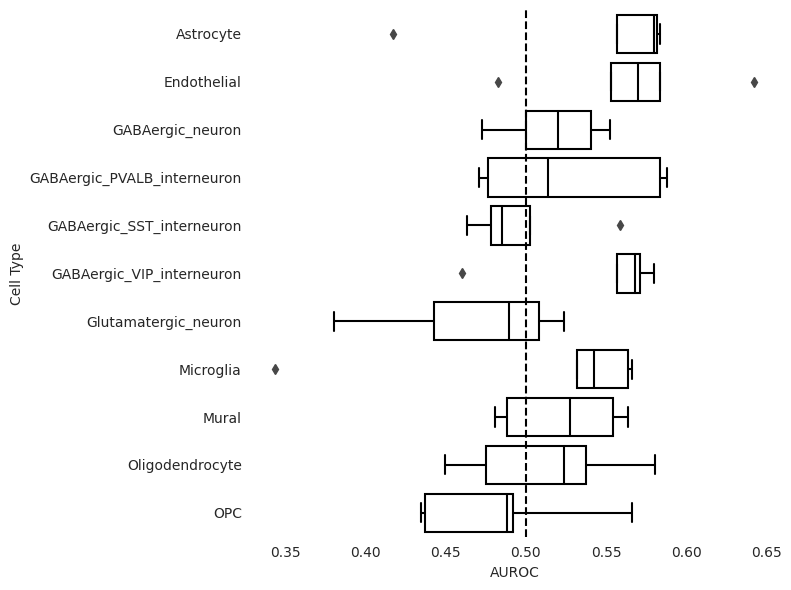

In [84]:
fig, axs = plt.subplots(1, 1, figsize=(8, 6), sharey=True)
axs = [axs]
# Barplot
sns.boxplot(ax=axs[0], data=df, x='auroc', y='cell_type', **style)
sns.despine(ax=axs[0], left=True, bottom=True)
# sns.boxplot(ax=axs[1], data=df, x='auprc', y='cell_type', **style)
# sns.despine(ax=axs[1], left=False, bottom=True)
# Labels
axs[0].set_xlabel('AUROC')
axs[0].set_ylabel('Cell Type')
axs[0].axvline(x=.5, color='black', linestyle='--')
# axs[1].set_xlabel('AUPRC')
# axs[1].set_ylabel(None)
plt.tight_layout()
# Save figure
plt.savefig('results/fig_performance.png', dpi=300, bbox_inches='tight')

In [85]:
import hiveplotlib as hpl
from hiveplotlib import Axis, Node, HivePlot
from hiveplotlib.converters import networkx_to_nodes_edges
from hiveplotlib.viz import axes_viz_mpl, node_viz_mpl, edge_viz_mpl

# Get best model
best_performing_model = np.argmax(np.concatenate(auroc_list))
print(f'Best performing model: {cell_types[best_performing_model // folds]} ({best_performing_model % folds}) ({auroc_list[best_performing_model // folds][best_performing_model % folds]:.3f})')
cell_type = cell_types[best_performing_model // folds]
wd = f'results/{cell_type}/fold{best_performing_model % folds}/'

Best performing model: Endothelial (3) (0.642)


In [86]:
# Get data
print('Loading data...')
data, labels, genes = get_data(cell_type)
subset_idx = np.concatenate([
    np.argwhere(labels=='AD').flatten(),
    # np.argwhere(labels=='notAD').flatten(),
    np.random.choice(np.argwhere(labels=='notAD').flatten(), len(np.argwhere(labels=='AD')), replace=False),
    # np.argwhere(labels=='unknown').flatten(),
    np.random.choice(np.argwhere(labels=='unknown').flatten(), 512, replace=False),
])
data = data.copy()[subset_idx]
labels = labels[subset_idx]
genes = genes[subset_idx]
ad_true = genes[np.argwhere(labels == 'AD').flatten()]
notad_true = genes[np.argwhere(labels == 'notAD').flatten()]

Loading data...


In [130]:
# Get predictions
ad_pred = np.intersect1d(np.loadtxt(wd + 'AD.txt', dtype=str), genes)
notad_pred = np.intersect1d(np.loadtxt(wd + 'notAD.txt', dtype=str), genes)

# Get logits
model = torch.load(wd + 'model.h5')
_, logits = model(torch.Tensor(data))
logits = logits[:, 1].detach()
print(f'Min logit: {min(logits)}\tMax logit: {max(logits)}')

# Create graph
print('Creating graph...')
# Format sparse
print('\tMaking sparse...')
sparse_data = data.copy()[:, subset_idx]
sparse_data[np.eye(sparse_data.shape[0] ,dtype=bool)] = 0  # Remove diagonal
sparse_data = 1.*(sparse_data > .3)  # Threshold
sparse_data = scipy.sparse.coo_matrix(sparse_data)
edge_indices = np.stack([sparse_data.row, sparse_data.col])
edge_indices = np.concatenate([edge_indices, edge_indices[::-1]], axis=1)  # Make undirected
edge_weights = np.concatenate([sparse_data.data, sparse_data.data])
# Construct pyg dataset
print('\tConstructing pyg...')
graph = pyg.data.Data(
    num_nodes=len(labels),
    node_name=genes,
    y=labels,
    edge_index=torch.tensor(edge_indices).to(torch.int64),
    edge_weight=torch.tensor(edge_weights).to(torch.float64))
# To networkx
print('\tConverting networkx...')
graph = pyg.utils.convert.to_networkx(graph, node_attrs=['node_name'], edge_attrs=['edge_weight'], to_undirected=True)
graph = nx.relabel_nodes(graph, lambda x: graph.nodes(data=True)[x]['node_name'], copy=False)
# Hiveplot format
print('\tConverting hp...')
nodes, edges = hpl.converters.networkx_to_nodes_edges(graph)

# Add node information
print('Computing features...')
deg_cen = nx.degree_centrality(graph)
# eig_cen = nx.eigenvector_centrality(graph)
clo_cen = nx.closeness_centrality(graph)
bet_cen = nx.betweenness_centrality(graph)
for node in nodes:
    new_data = {}
    new_data['deg'] = deg_cen[node.data['node_name']]
    # new_data['eig'] = eig_cen[node.data['node_name']]
    new_data['clo'] = clo_cen[node.data['node_name']]
    new_data['bet'] = bet_cen[node.data['node_name']]
    new_data['pad'] = float(logits[np.argwhere(genes==node.data['node_name'])[0][0]].flatten())
    new_data['pnad'] = float(1-logits[np.argwhere(genes==node.data['node_name'])[0][0]].flatten())
    node.add_data(data=new_data)

# Add node information
# print('Getting weights...')
# edge_str = np.array([' '.join(g) for g in genes[edge_indices.T]])
# weights = np.array([edge_weights[np.argwhere(edge_str == ' '.join(e))[0][0]] for e in edges])

Loading data...
Min logit: 0.17871609330177307	Max logit: 0.9945483803749084
Creating graph...
	Making sparse...
	Constructing pyg...
	Converting networkx...
	Converting hp...
Computing features...


## Preview

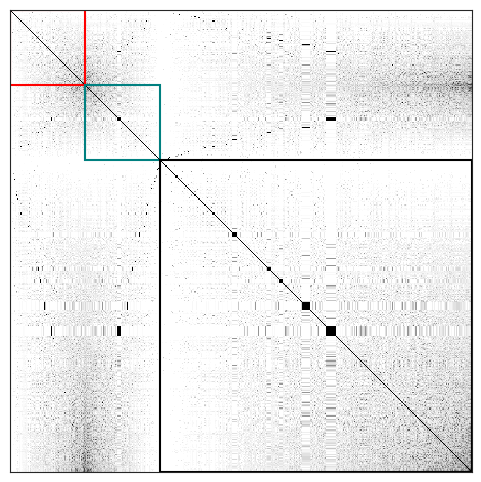

In [87]:
# Get data
adj_matrix = data[:, subset_idx]
block_list = [np.argwhere(labels=='AD'), np.argwhere(labels=='notAD'), np.argwhere(labels=='unknown')]
block_colors = ['red', 'teal', 'black']

# Sort data
idx_list = list(range(len(subset_idx)))
order_ad = [0 if labels[idx]=='AD' else (1 if labels[idx]=='notAD' else 2) for idx in idx_list]
order_sum = -adj_matrix.sum(axis=1)
order_sum = [os if order_ad[idx]%2!=0 else -os for idx, os in enumerate(order_sum)]  # Smooth visual
order = list(np.stack([idx_list, order_ad, order_sum]).T)
import operator
order.sort(key=operator.itemgetter(1,2))
order = np.array(order)[:, 0].astype(int)

# Plot data
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plt.imshow(adj_matrix[order, :][:, order], cmap='Greys', interpolation='none')

# Plot boxes
# http://sociograph.blogspot.com/2012/11/visualizing-adjacency-matrices-in-python.html
from matplotlib import patches
current_idx = 0
for block, color in zip(block_list, block_colors):
    ax.add_patch(patches.Rectangle((current_idx, current_idx),
                                   block.shape[0],
                                   block.shape[0],
                                   facecolor='none',
                                   edgecolor=color,
                                   linewidth=1.5))
    current_idx += block.shape[0]
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('results/fig_data.png', dpi=300)

## Hive

In [132]:
%%capture
from matplotlib.lines import Line2D

# Legend
legend = [
    Line2D([], [], markerfacecolor='red', markeredgecolor='red', marker=(2, 0, 20), linestyle='None', markersize=10),
    Line2D([], [], markerfacecolor='teal', markeredgecolor='teal', marker=(2, 0, 20), linestyle='None', markersize=10),
    Line2D([], [], markerfacecolor='teal', markeredgecolor='black', marker=(2, 0, 20), linestyle='None', markersize=10),
    Line2D([], [], color=f'black', lw=1, linestyle='-')]
legend_names = ['AD Genes', 'Non-AD Genes', 'Unknown Genes', 'Coregulation']

# Plot legend
fig, ax = plt.subplots()
legend = ax.legend(legend, legend_names, loc='center', frameon=False, ncol=len(legend)//1)
legend.figure.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.axis('off')
plt.tight_layout()
plt.savefig('results/fig_legend.png', bbox_inches=bbox, dpi=300)

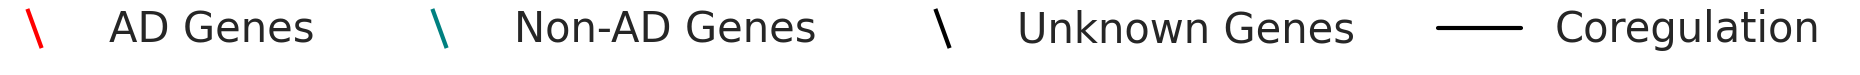

In [133]:
# Preview
from IPython.display import display, Image
display( Image(filename='results/fig_legend.png', width=800) )

Creating Hive Plot...


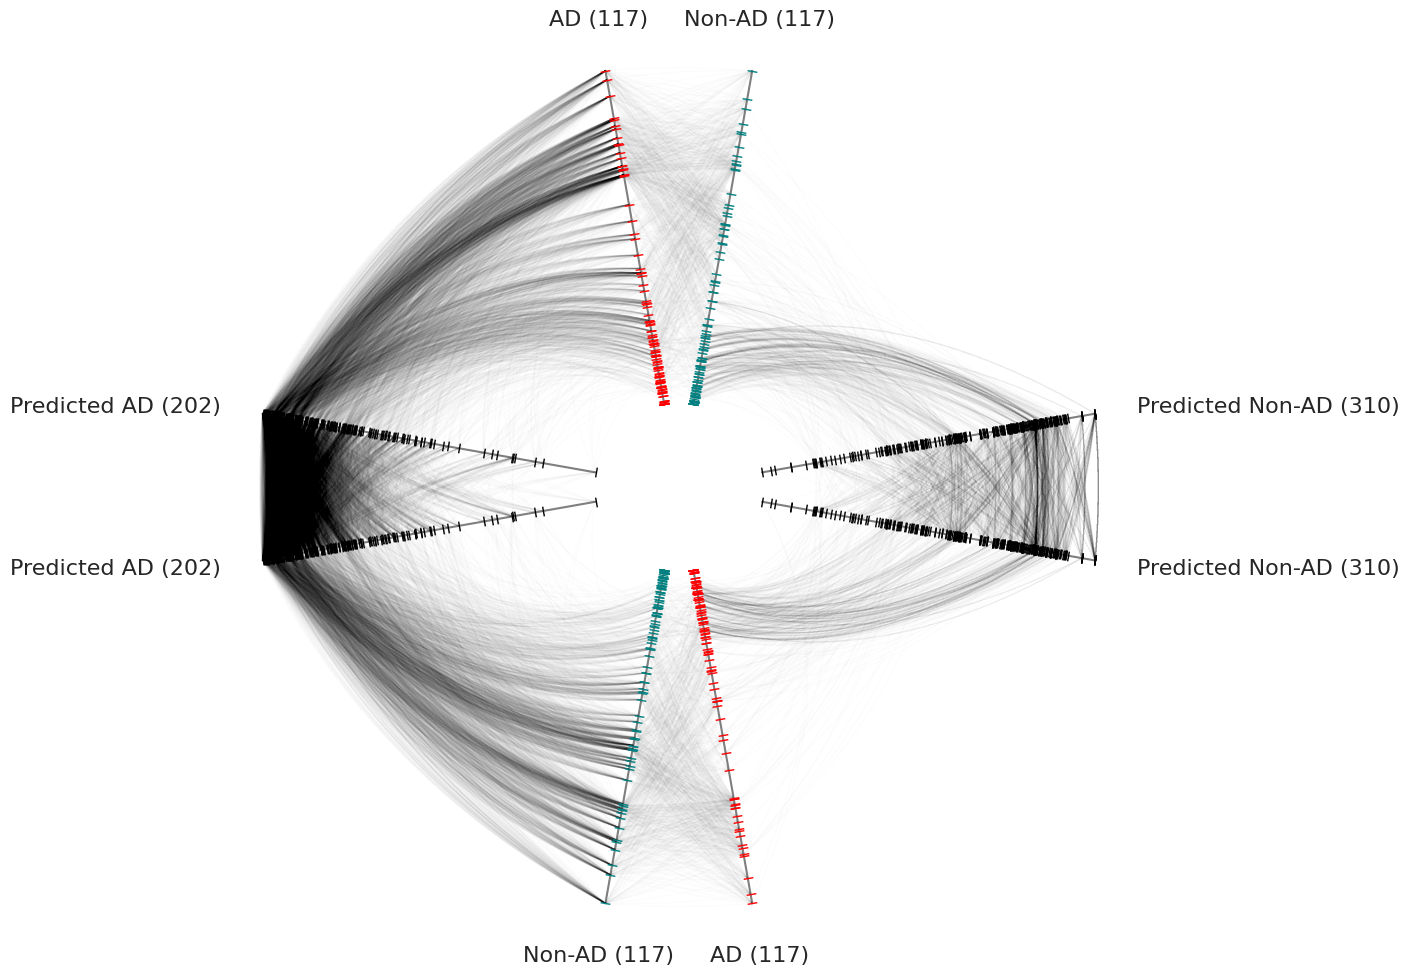

In [135]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Create Hive Plot
print('Creating Hive Plot...')
hp = HivePlot()
hp.add_nodes(nodes)

# Axes
def get_id():
    count = 0
    while True:
        yield count
        count += 1
id_inst = get_id()
default_sort = 'deg'
axes, unique_idss, sorting_feature_to_uses = [], [], []
axes.append(Axis(axis_id=next(id_inst), start=1, end=5, angle=-10, long_name=f'Predicted Non-AD ({len(notad_pred)})'))
unique_idss.append(notad_pred)
sorting_feature_to_uses.append('pnad')
axes.append(Axis(axis_id=next(id_inst), start=1, end=5, angle=10, long_name=f'Predicted Non-AD ({len(notad_pred)})'))
unique_idss.append(notad_pred)
sorting_feature_to_uses.append('pnad')
axes.append(Axis(axis_id=next(id_inst), start=1, end=5, angle=80, long_name=f'Non-AD ({len(notad_true)})'))
unique_idss.append(notad_true)
sorting_feature_to_uses.append(default_sort)
axes.append(Axis(axis_id=next(id_inst), start=1, end=5, angle=100, long_name=f'AD ({len(ad_true)})'))
unique_idss.append(ad_true)
sorting_feature_to_uses.append(default_sort)
axes.append(Axis(axis_id=next(id_inst), start=1, end=5, angle=170, long_name=f'Predicted AD ({len(ad_pred)})'))
unique_idss.append(ad_pred)
sorting_feature_to_uses.append('pad')
axes.append(Axis(axis_id=next(id_inst), start=1, end=5, angle=190, long_name=f'Predicted AD ({len(ad_pred)})'))
unique_idss.append(ad_pred)
sorting_feature_to_uses.append('pad')
axes.append(Axis(axis_id=next(id_inst), start=1, end=5, angle=260, long_name=f'Non-AD ({len(notad_true)})'))
unique_idss.append(notad_true)
sorting_feature_to_uses.append(default_sort)
axes.append(Axis(axis_id=next(id_inst), start=1, end=5, angle=280, long_name=f'AD ({len(ad_true)})'))
unique_idss.append(ad_true)
sorting_feature_to_uses.append(default_sort)
hp.add_axes(axes)

# Nodes
for axis, unique_ids, sorting_feature_to_use in zip(axes, unique_idss, sorting_feature_to_uses):
    kwargs = {}
    # if sorting_feature_to_use != default_sort:
    #     kwargs['vmin'] = .5
    #     kwargs['vmax'] = 1
    hp.place_nodes_on_axis(axis_id=axis.axis_id, unique_ids=unique_ids, sorting_feature_to_use=sorting_feature_to_use, **kwargs)

# Edges
for i in range(len(axes)):
    hp.connect_axes(edges=edges, axis_id_1=axes[i].axis_id, axis_id_2=axes[(i+1)%len(axes)].axis_id, color='black')

# Plot
axes_viz_mpl(hp, fig=fig, ax=ax)
edge_viz_mpl(hp, fig=fig, ax=ax, alpha=.01, zorder=-1, linewidth=1.)

# Mark Nodes
for hp_ax in hp.axes.values():
    locations = hp_ax.node_placements
    ad_locations_mask = np.array([g in ad_true for g in locations.loc[:, 'unique_id']])
    notad_locations_mask = np.array([g in notad_true for g in locations.loc[:, 'unique_id']])
    for x, y in list(locations.loc[ad_locations_mask, ['x', 'y']].values):
        ax.scatter(x, y, color='red', marker=(2, 0, hp_ax.angle), s=50, lw=1, alpha=1., zorder=4)
    for x, y in list(locations.loc[notad_locations_mask, ['x', 'y']].values):
        ax.scatter(x, y, color='teal', marker=(2, 0, hp_ax.angle), s=50, lw=1, alpha=1., zorder=3)
    for x, y in list(locations.loc[~(ad_locations_mask + notad_locations_mask), ['x', 'y']].values):
        ax.scatter(x, y, color='black', marker=(2, 0, hp_ax.angle), s=50, lw=1, alpha=1., zorder=2)

plt.savefig('results/fig_prediction.png', dpi=300, bbox_inches='tight')

## Common AD

In [89]:
import itertools

# Find common AD genes
gene_counts = {}
folder_num = 0
for i, (cell_type, k) in enumerate(itertools.product(cell_types, range(folds))):
    # Only use best fold
    if auroc_list[i // folds][i % folds] != max(auroc_list[i // folds]):
        continue
    folder_num += 1
    results_dir = f'results/{cell_type}/fold{k}/'
    
    num_top_genes = len(ad_genes)  # 100
    # Add AD genes
    ad_genes = list(np.loadtxt(results_dir + 'AD.txt', dtype=str))
    for g in ad_genes[:num_top_genes]:
        if g not in gene_counts:
            gene_counts[g] = 0
        gene_counts[g] += 1
    # Add notAD genes
    notad_genes = list(np.loadtxt(results_dir + 'notAD.txt', dtype=str))
    for g in ad_genes[num_top_genes:] + notad_genes:
        if g not in gene_counts:
            gene_counts[g] = 0
filtered_ad_genes = [g for g, v in gene_counts.items() if v > 1]
filtered_strongad_genes = [g for g, v in gene_counts.items() if v > int(.4*folder_num)]
np.savetxt('results/commonAD.txt', filtered_ad_genes, fmt='%s')
np.savetxt('results/commonstrongAD.txt', filtered_strongad_genes, fmt='%s')

/tmp/ipykernel_6522/3897588771.py:15: UserWarning: loadtxt: input contained no data: "results/GABAergic_VIP_interneuron/fold4/AD.txt"
  ad_genes = list(np.loadtxt(results_dir + 'AD.txt', dtype=str))
/tmp/ipykernel_6522/3897588771.py:15: UserWarning: loadtxt: input contained no data: "results/Glutamatergic_neuron/fold3/AD.txt"
  ad_genes = list(np.loadtxt(results_dir + 'AD.txt', dtype=str))
/tmp/ipykernel_6522/3897588771.py:21: UserWarning: loadtxt: input contained no data: "results/Mural/fold4/notAD.txt"
  notad_genes = list(np.loadtxt(results_dir + 'notAD.txt', dtype=str))
/tmp/ipykernel_6522/3897588771.py:15: UserWarning: loadtxt: input contained no data: "results/Oligodendrocyte/fold2/AD.txt"
  ad_genes = list(np.loadtxt(results_dir + 'AD.txt', dtype=str))
/tmp/ipykernel_6522/3897588771.py:21: UserWarning: loadtxt: input contained no data: "results/OPC/fold2/notAD.txt"
  notad_genes = list(np.loadtxt(results_dir + 'notAD.txt', dtype=str))
